## Star Wars Jedi
### A look at lightsabers, species, gender, rank, and date of death.

This project takes a look at the commonality of different lightsaber colors. After watching and reading nearly everything Star Wars, 
I began to wonder if it just seemed like there was a large number of blue and green sabers, or if there really were many more of 
these blade colors.

I also wondered about how many Jedi there were from each species. While it has always been obvious that there are more humans than 
other species among the Jedi, I wondered whether there was another species that stood out as well.

Of all the Jedi spoken of in movies and books, how many are Masters? How many are Knigts or Padowans? This data helped me look into 
that and see what the distribution is among the known Jedi characters.

And lastly, I wondered how many Jedi died before or after the purge of Order 66. Did a lot of Jedi die before Order 66, or maybe a
few afterward? 

In [2]:
import numpy as np
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import re


##### First, I needed some data to work with. 
I was able to find some good data for this posted by CanePlayz (thank you!) on https://starwars.fandom.com/f/u/27777468 
and I downloaded  the .csv file (https://bit.ly/3A844WP) to use in this project. 

While I cannot confirm that this data is 100% correct, and I'm sure
it is not complete since Star Wars is such a large and expansive topic, it looked like a decent and relatively accurate
set of data for my purposes. 


In [3]:
#Read in the date from the csv file.
jedi_csv=pd.read_csv(r"List of All Jedi [Canon] - List of Jedi.csv")



I need to get rid of extraneous data in that file. There's a lot of information at the end of the file that covered unverified Jedi appearances, and I didn't need that for this project, only the verified entries.

In [4]:
#This chops the extra rows from the dataframe. From this row in the file the csv file contained only 
#unverified Jedi.
jedi_csv=jedi_csv[0:170]



At this point I need to look at the existing columns so I can get a feel of what data I have available to work with.

In [5]:
#Take a look at the list of the existing columns in this data set.
jedi_csv.columns



Index(['Name', 'Rank', 'Lightsaber', 'Death', 'Species and gender',
       'Leaving/getting banned from the Jedi Order', 'Jedi Master(s)',
       'Jedi Apprentice(s)', 'Wookieepedia article'],
      dtype='object')

There are several columns that I'm completely certain I'm not going to use in this analysis, so I can drop those now.

In [6]:
#Drop unneeded columns.
jedi_csv=jedi_csv.drop('Leaving/getting banned from the Jedi Order',axis=1)
jedi_csv=jedi_csv.drop('Wookieepedia article',axis=1)



The Species and gender column needs to be split apart. I'm going to be looking at each of these separately, so I'll want to put those into their own columns.

While I'm at it, I'm going to clean up some of the data in here.

In [7]:
#Break gender into its own column, separate from species
jedi_csv['Gender']=jedi_csv["Species and gender"].str.rsplit(" ", 1).str[-1]



In [8]:
#Replace NaN in the Gender column with 'Unknown'
jedi_csv['Gender']=jedi_csv['Gender'].fillna("Unknown")



In [9]:
#Let's take a quick look to see how our Gender column is showing up
pd.unique(jedi_csv['Gender'])



array(['female', 'male', 'Male', 'Female', 'Unknown', "Twi'lek",
       'species'], dtype=object)

In [10]:
#We have some entries there that we don't want, so let's take care of that.
jedi_csv['Gender']=jedi_csv['Gender'].replace('Species','Unknown')
jedi_csv['Gender']=jedi_csv['Gender'].replace("Twi'lek",'Unknown')

In [11]:
#Verify our data in our Gender column looks right now.
pd.unique(jedi_csv['Gender'])

array(['female', 'male', 'Male', 'Female', 'Unknown', 'species'],
      dtype=object)

In [12]:
#We need to correct and normalize a couple of things there.
jedi_csv['Gender']=jedi_csv['Gender'].str.lower()
jedi_csv['Gender']=jedi_csv['Gender'].str.capitalize()
jedi_csv['Gender']=jedi_csv['Gender'].str.replace("Species","Unknown")



In [13]:
#Now check that at our data in our Gender column looks right now.
pd.unique(jedi_csv['Gender'])



array(['Female', 'Male', 'Unknown'], dtype=object)

Rather than try to separate species into its own column, I'm going to remove the gender from that one now and clean up the data in the column.

I'll also rename the column, since it will now only contain the species.

In [14]:
#Get rid of female and male in Species and gender column. 
jedi_csv['Species and gender']=jedi_csv['Species and gender'].str.replace("female"," ")
jedi_csv['Species and gender']=jedi_csv['Species and gender'].str.replace("Female"," ")
jedi_csv['Species and gender']=jedi_csv['Species and gender'].str.replace("male"," ")
jedi_csv['Species and gender']=jedi_csv['Species and gender'].str.replace("Male"," ")

#Take care of NaN and blank lines in this field and blanks and replace them with "Unknown"
jedi_csv['Species and gender']=jedi_csv['Species and gender'].replace(np.nan,"Unknown")
jedi_csv['Species and gender'] = jedi_csv['Species and gender'].replace(r'^\s*$', "Unknown", regex=True)

#Rename that column, since it now only contains species
jedi_csv.rename(columns={'Species and gender':'Species'}, inplace=True)



Now that the Species column is cleaned up and Gender has been separated into its own column, I'm going to work on the Lightsaber column.

One thing I want to do is separate the lightsaber color and lightsaber type into their own columns. This will make it possible to show a count of each in a charts later on.

It needs quite a bit of cleaning up. There are a lot of NaN fields, so I need to take care of that. I'll also need to convert a lot of the data within the column to a more usable format. 


In [15]:
#See what unique values exist in the Lightsaber column
pd.unique(jedi_csv['Lightsaber'])




array(['Blue', 'Blue and green (hybrid)', '2 green -> 2 blue -> 2 white',
       nan, 'Blue, later red', 'Green, later 2 red', 'Green',
       'Later red (IQ)', 'Blue, later green', 'Purple',
       'Lightsaber sniper rifle', 'Blue and green (double)', 'Later red',
       'Blue, later yellow', '2 (unkn. colours), later 2 red',
       'Black (Darksaber)', 'Yellow (double), later red (IQ)'],
      dtype=object)

In [16]:
#Replace those Nan values with "Unknown".
jedi_csv['Lightsaber']=jedi_csv['Lightsaber'].replace(np.nan,"Unknown")

#First, I'll add the new column
jedi_csv['Lightsaber Type']="Unknown" #Unknown is the default value

#Now I'll take care of each of these entries
#I'm going to use Single Blade, Double Blade, Two Single, Sniper Rifle, Hybrid Single Blade as the values I'll lump
#these into. It should cover all cases fairly well. 
jedi_csv.loc[jedi_csv['Lightsaber']=="2 (unkn. colours), later 2 red",'Lightsaber Type']="Two Single Blades"
jedi_csv.loc[jedi_csv['Lightsaber']=='2 green -> 2 blue -> 2 white','Lightsaber Type']="Two Single Blades"
jedi_csv.loc[jedi_csv['Lightsaber']=='Black (Darksaber)','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue and green (double)','Lightsaber Type']="Dual Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue and green (hybrid)','Lightsaber Type']="Hybrid Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue, later green','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue, later red','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue, later yellow','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Green','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Green, later 2 red','Lightsaber Type']="Single Blade, Two Single Blades"
jedi_csv.loc[jedi_csv['Lightsaber']=='Later red','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Later red (IQ)','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Lightsaber sniper rifle','Lightsaber Type']="Sniper Rifle"
jedi_csv.loc[jedi_csv['Lightsaber']=='Purple','Lightsaber Type']="Single Blade"
jedi_csv.loc[jedi_csv['Lightsaber']=='Yellow (double), later red (IQ)','Lightsaber Type']="Dual Blade"

#Check to see if that column looks right now
pd.unique(jedi_csv['Lightsaber Type'])



array(['Single Blade', 'Hybrid Single Blade', 'Two Single Blades',
       'Unknown', 'Single Blade, Two Single Blades', 'Sniper Rifle',
       'Dual Blade'], dtype=object)

In [17]:
#Add a new field, 'Lightsaber Color' to hold that part of the data
jedi_csv['Lightsaber Color']="Unknown" #Unknown is the default value

#Values are going to be Blue, Red, Green, White, Yellow, Purple, Dark Saber, and Multiple
jedi_csv.loc[jedi_csv['Lightsaber']=='2 green -> 2 blue -> 2 white','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Black (Darksaber)','Lightsaber Color']="Dark Saber"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue','Lightsaber Color']="Blue"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue and green (double)','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue and green (hybrid)','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue, later green','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue, later red','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Blue, later yellow','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Green','Lightsaber Color']="Green"
jedi_csv.loc[jedi_csv['Lightsaber']=='Green, later 2 red','Lightsaber Color']="Multiple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Later red','Lightsaber Color']="Red"
jedi_csv.loc[jedi_csv['Lightsaber']=='Later red (IQ)','Lightsaber Color']="Red"
jedi_csv.loc[jedi_csv['Lightsaber']=='Purple','Lightsaber Color']="Purple"
jedi_csv.loc[jedi_csv['Lightsaber']=='Yellow (double), later red (IQ)','Lightsaber Color']="Multiple" 

#Verify that worked out correctly
pd.unique(jedi_csv['Lightsaber Color'])



array(['Blue', 'Multiple', 'Unknown', 'Green', 'Red', 'Purple',
       'Dark Saber'], dtype=object)

In [18]:
jedi_csv.columns



Index(['Name', 'Rank', 'Lightsaber', 'Death', 'Species', 'Jedi Master(s)',
       'Jedi Apprentice(s)', 'Gender', 'Lightsaber Type', 'Lightsaber Color'],
      dtype='object')

Now that I've taken care of the Lightsaber column, I'll need to look at the Death column.

This really should be separated out into date of death and cause of death columns. I don't know if I'm ever going to use the cause of death data, but it definitely should be in a separate column. This will allow me to look at each of those pieces of data separately.

I'll also need to clean up the data I find here.

In [19]:
#First, I'll drop that Lightsaber column, since I won't need it now
jedi_csv=jedi_csv.drop('Lightsaber', axis=1)

#We should split Death into Date of Death and Cause of Death

jedi_csv['Date of Death']="Unknown" #Unknown is the default value
jedi_csv['Cause of Death']="Unknown" #Unknown is the default value

#Get the Cause of death
jedi_csv['Cause of Death']=jedi_csv["Death"].str.rsplit(",", 1).str[-1]
jedi_csv['Date of Death']=jedi_csv["Death"].str.rsplit(",", 1).str[0]

#Replace NaN with unknown
jedi_csv['Cause of Death']=jedi_csv['Cause of Death'].replace(np.nan,"Unknown")
jedi_csv['Date of Death']=jedi_csv['Date of Death'].replace(np.nan,"Unknown")

#Capitalize those fields to normalize everything
jedi_csv['Cause of Death']=jedi_csv['Cause of Death'].str.strip()
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.strip()

jedi_csv['Cause of Death']=jedi_csv['Cause of Death'].str.capitalize()
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.capitalize()

#See how it looks now
jedi_csv.sample(20)



,Name,Rank,Death,Species,Jedi Master(s),Jedi Apprentice(s),Gender,Lightsaber Type,Lightsaber Color,Date of Death,Cause of Death
139,Tan Yuster,Jedi Padawan,"22 BBY, killed by Separatist battle droids on ...",Human,Agen Kolar,NaN,Male,Single Blade,Blue,22 bby,Killed by separatist battle droids on geonosis
12,Barriss Offee,Jedi Padawan,NaN,Mirialan,Luminara Unduli,NaN,Female,Single Blade,Blue,Unknown,Unknown
46,Grogu,Jedi youngling,NaN,Yoda's species,NaN,NaN,Male,Unknown,Unknown,Unknown,Unknown
145,"The ""Wanderer""",NaN,NaN,Human,NaN,NaN,Male,Single Blade,Green,Unknown,Unknown
68,Kirak Infil'a,Jedi Master,"19 BBY, killed by Darth Vader on the river moo...",Unknown,NaN,NaN,Unknown,Single Blade,Green,19 bby,Killed by darth vader on the river moon of al'...
25,Coleman Trebor,Jedi Master (HCM),"22 BBY, killed by Jango Fett on Geonosis",Vurk,NaN,NaN,Male,Single Blade,Green,22 bby,Killed by jango fett on geonosis
44,Ganodi,Jedi youngling,NaN,Rodian,NaN,NaN,Female,Single Blade,Green,Unknown,Unknown
4,Akar-Deshu,Jedi Knight,"19 BBY, killed by Quinlas Vos aboard the Vigil...",Mahran,NaN,NaN,Male,Single Blade,Blue,19 bby,Killed by quinlas vos aboard the vigilance
128,Sephjet Josall,Jedi Knight,NaN,Human,NaN,NaN,Male,Single Blade,Blue,Unknown,Unknown
38,Ezra Bridger,Jedi Padawan,NaN,Human,NaN,NaN,Male,Single Blade,Multiple,Unknown,Unknown


The Date of Death column is a difficult one. There are a variety of entries, but all I really want is the first year we come across, not all the text modifying that.

While I will need to know BBY (Before Battle of Yavin) and ABY (After Battle of Yavin) so I can assign BBY as a negative number for graphing purposes, I don't need the other qualifying text. In fact, this should be a numerical column.

In [20]:
#Let's take a closer look at that Date of Death column
pd.unique(jedi_csv['Date of Death'])



array(['19 bby', '20 bby', 'Unknown', '4 aby', '35 aby', '18 bby',
       '21 bby', '22 bby', 'Between 18 bby and 14 bby', '3 bby',
       'Around 32 bby', 'Prior to 22 bby', 'Sometime prior to 19 bby',
       '0 bby', 'Sometime prior to 22 bby', '34 aby',
       'Between 19 bby and 18 bby', 'Around 30 aby',
       'Sometime prior to 0 bby', 'Around 48 bby',
       'Within a decade of the corsair wars', '32 bby',
       '35 aby, killed by darth sidious on exegol', '14 bby',
       'Prior to the establishment of the galactic republic', 'By 9 bby',
       '4 bby', 'Between 22 bby and 20 bby', '32 bby - 22 bby',
       '4 aby on dagobah'], dtype=object)

In [21]:
#Replace all the "between x bby and y bby" with x-y bby
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace(" bby and ","-")

#Get rid of "Between"
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("Between ","")

#Get rid of remaining " bby - " entries to take care of
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace(" bby - ","-")

#Get rid of "Around","Prior to", "By", and "Sometime"
#Don't need "around" because we are close enough for our uses by just using year
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("Around","") 
#Sometime is just a waste of space for us here
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("Sometime","") 
#Before covers this more succinctly
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("Prior to","Before") 
#Before covers this more succinctly
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("prior to","Before") 
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("By","") #See Around above

#Clean up that reference to the Corsair wars, 'Before the establishment of the galactic republic', and " on dagobah"
#Corsair Wars were prior to 19 BBY per Starwars.fandom.com
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace('Within a decade of the corsair wars',"By 19 BBY") 
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace('Before the establishment of the galactic republic',"By 25,000 BBY") #Per Starwars.fandom.com
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace(" on dagobah","")

#Upper case all those bby and aby first
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("bby","BBY") 
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace("aby","ABY") 

#trip away extra space at ends of column data
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.strip()

#See how things stand now
pd.unique(jedi_csv['Date of Death'])

array(['19 BBY', '20 BBY', 'Unknown', '4 ABY', '35 ABY', '18 BBY',
       '21 BBY', '22 BBY', '18-14 BBY', '3 BBY', '32 BBY',
       'Before 22 BBY', 'Before 19 BBY', '0 BBY', '34 ABY', '19-18 BBY',
       '30 ABY', 'Before 0 BBY', '48 BBY', 'By 19 BBY',
       '35 ABY, killed by darth sidious on exegol', '14 BBY',
       'By 25,000 BBY', '9 BBY', '4 BBY', '22-20 BBY', '32-22 BBY'],
      dtype=object)

There is still a problematic entry with darth sidious mentioned, so I need to take care of that.

In [22]:
#Clean up the entry with darth sidious mentioned
jedi_csv['Date of Death']=jedi_csv['Date of Death'].str.replace('35 ABY, killed by darth sidious on exegol',"35 BBY") 



In [23]:
#Let's see where we're at with that Date of Death now
pd.unique(jedi_csv['Date of Death'])



array(['19 BBY', '20 BBY', 'Unknown', '4 ABY', '35 ABY', '18 BBY',
       '21 BBY', '22 BBY', '18-14 BBY', '3 BBY', '32 BBY',
       'Before 22 BBY', 'Before 19 BBY', '0 BBY', '34 ABY', '19-18 BBY',
       '30 ABY', 'Before 0 BBY', '48 BBY', 'By 19 BBY', '35 BBY',
       '14 BBY', 'By 25,000 BBY', '9 BBY', '4 BBY', '22-20 BBY',
       '32-22 BBY'], dtype=object)

The Date of Death column looks pretty good now, so I'll move on to Cause of Death. 

I need to clean up the values so that they only show the way they died. I don't need to know which planet or ship they died on.

I also need to upper case a lot of names in here. 

In [24]:
#See what it shows right now
pd.unique(jedi_csv['Cause of Death'])



array(['Killed by clone troopers during order 66 on felucia',
       'Killed by savage opress on florrum',
       'Killed by darth sidious on coruscant', 'Unknown',
       'Killed by quinlas vos aboard the vigilance',
       'Sacrificed his life for luke skywalker on the death star ii',
       'Killed by dooku on christophisis',
       'Sacrificed his life for rey on exegol',
       'Killed by darth vader on coruscant',
       'Killed by ahsoka tano on raada',
       'Killed by cad bane in the devaron system',
       'Killed by clone troopers during order 66 on zeffo',
       'Killed by jango fett on geonosis',
       'Killed by anakin skywalker aboard the invisible hand',
       'Killed by clone troopers during order 66 on kaller',
       'Killed by darth vader', 'Killed by kanan jarrus on malachor',
       'Killed by darth maul on the moon of drazkel',
       'Killed by an anooba on lola sayu',
       'Killed by darth vader on mon cala', 'Killed by maul on malachor',
       'Killed b

In [25]:
#Get rid of all of those "on ..."
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.rsplit(" on", 1).str[0]

#Get rid of "in the ... system"
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.rsplit(" in the", 1).str[0]

#Get rid of "over ... system"
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.rsplit(" over ", 1).str[0]

#Uppercase those names and titles
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('darth',"Darth")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('sidious',"Sidious")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('maul',"Maul")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('skywalker',"Skywalker")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('anakin',"Anakin")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('luke',"Luke")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('vader',"Vader")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('grievous',"Grievous")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('dooku',"Dooku")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('cad bane',"Cad Bane")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('dogma',"Dogma")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('ahsoka tano',"Ahsoka Tano")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('anooba',"Anooba")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('kanan jarrus',"Kanan Jarrus")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('jango fett',"Jango Fett")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('vizsla keep',"Vizsla Keep")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('cal kestis',"Cal Kestis")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('merrin',"Merrin")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('the sovereign',"the Sovereign")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('asajj ventress',"Asajj Ventress")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('barris offee',"Barriss Offee")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('advent ',"Advent ")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace(' rey'," Rey")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('the invisible hand',"the Invisible Hand")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('quinlan vos',"Quinlan Vos")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('quinlas vos',"Quinlan Vos")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('sidious',"Sidious")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('jedi',"Jedi")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('the vigilance',"the Vigilance")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('savage opress',"Savage Opress")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('ringo vinda',"Ringa Vinda")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('weequay',"Weequay")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('the ghost',"the Ghost")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('order 66',"Order 66")
jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace(' tup'," Tup")

#Set values that don't really show a cause of death to Unknown
jedi_csv['Cause of Death']=np.where(jedi_csv['Cause of Death'].isin(['21 bby','32 bby - 22 bby','4 aby', 'By 9 bby','Sometime prior to 0 bby']),"Unknown",jedi_csv['Cause of Death'])

#Let's see how it stands now
pd.unique(jedi_csv['Cause of Death'])

array(['Killed by clone troopers during Order 66',
       'Killed by Savage Opress', 'Killed by Darth Sidious', 'Unknown',
       'Killed by Quinlan Vos aboard the Vigilance',
       'Sacrificed his life for Luke Skywalker', 'Killed by Dooku',
       'Sacrificed his life for Rey', 'Killed by Darth Vader',
       'Killed by Ahsoka Tano', 'Killed by Cad Bane',
       'Killed by Jango Fett',
       'Killed by Anakin Skywalker aboard the Invisible Hand',
       'Killed by Kanan Jarrus', 'Killed by Darth Maul',
       'Killed by an Anooba', 'Killed by Maul',
       'Killed by separatist battle droids', 'Killed by Grievous',
       'Sacrificed his life for the Ghost crew',
       'Killed by Weequay raiders',
       'Died on ajan kloss after reaching out to ben solo', 'Died',
       'Killed', 'Killed by Darth Sidious and Anakin Skywalker',
       'Killed when the crew of the freighter Advent mutinied',
       'Purged by other Jedi', 'Killed by Dogma',
       'Killed by purge troopers', 'Later

In [26]:
#Take care of some of the remaining problematic entries

jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('Prior to the establishment of the galactic republic',"Unknown")

jedi_csv['Cause of Death']=jedi_csv["Cause of Death"].str.replace('Utupau',"Unknown")



In [27]:
#Let's see the data looks now
pd.unique(jedi_csv['Cause of Death'])



array(['Killed by clone troopers during Order 66',
       'Killed by Savage Opress', 'Killed by Darth Sidious', 'Unknown',
       'Killed by Quinlan Vos aboard the Vigilance',
       'Sacrificed his life for Luke Skywalker', 'Killed by Dooku',
       'Sacrificed his life for Rey', 'Killed by Darth Vader',
       'Killed by Ahsoka Tano', 'Killed by Cad Bane',
       'Killed by Jango Fett',
       'Killed by Anakin Skywalker aboard the Invisible Hand',
       'Killed by Kanan Jarrus', 'Killed by Darth Maul',
       'Killed by an Anooba', 'Killed by Maul',
       'Killed by separatist battle droids', 'Killed by Grievous',
       'Sacrificed his life for the Ghost crew',
       'Killed by Weequay raiders',
       'Died on ajan kloss after reaching out to ben solo', 'Died',
       'Killed', 'Killed by Darth Sidious and Anakin Skywalker',
       'Killed when the crew of the freighter Advent mutinied',
       'Purged by other Jedi', 'Killed by Dogma',
       'Killed by purge troopers', 'Later

That looks pretty good. 

I'm going to drop the Death column, since I'll no longer need it.

I need to look at my data and see what else I need to do with it. I know there were a couple of things, like I need to replace some NaN values, but I need to see what else I'll need to change.

In [28]:
#Drop Death column
jedi_csv=jedi_csv.drop('Death',axis=1)

#Look at our current data
jedi_csv.sample(10)



,Name,Rank,Species,Jedi Master(s),Jedi Apprentice(s),Gender,Lightsaber Type,Lightsaber Color,Date of Death,Cause of Death
102,Oslord,Jedi Master,Unknown,NaN,NaN,Male,Unknown,Unknown,Unknown,Unknown
67,Ki-Adi Mundi,Jedi Master (HCM),Cerean,NaN,NaN,Male,Single Blade,Blue,19 BBY,Killed by clone troopers during Order 66
30,Depa Billaba,Jedi Master (HCM),Human,Mace Windu,Caleb Dume,Female,Single Blade,Green,19 BBY,Killed by clone troopers during Order 66
45,Gretz Droom,Jedi Master (HCM),Unknown,NaN,NaN,Male,Unknown,Unknown,Unknown,Unknown
0,Aayla Secura,Jedi Master,Twi'lek,Quinlan Vos,NaN,Female,Single Blade,Blue,19 BBY,Killed by clone troopers during Order 66
94,O-Mer,Jedi youngling,Cerean,NaN,NaN,Male,Unknown,Unknown,Unknown,Unknown
61,Kalifa,Jedi youngling,Human,NaN,NaN,Female,Unknown,Unknown,Unknown,Unknown
110,Pong Krell,Jedi Master,Besalisk,NaN,NaN,Male,Dual Blade,Multiple,20 BBY,Killed by Dogma
47,Gungi,Jedi youngling,Wookiee,NaN,NaN,Male,Single Blade,Green,Unknown,Unknown
162,Yaddle,Jedi Master (HCM),Yoda's species,NaN,NaN,Female,Single Blade,Green,Unknown,Unknown


In [29]:
# "Eight Brother" should be "Eighth Brother"
jedi_csv['Name']=jedi_csv['Name'].str.replace("Eight Brother","Eighth Brother")

#Replace NaN with "Sith" if they are a known sith, such as Eighth Brother or Fifth Brother
jedi_csv['Rank']=np.where(jedi_csv['Name'].str.contains('Brother'),"Sith",jedi_csv['Rank'])
jedi_csv['Rank']=np.where(jedi_csv['Name'].str.contains('Sister'),"Sith",jedi_csv['Rank'])

#Jedi Master(s) NaN need fixed
jedi_csv['Jedi Master(s)']=jedi_csv['Jedi Master(s)'].replace(np.nan,"Unknown")

#Jedi Apprentice(s) NaN need fixed
jedi_csv['Jedi Apprentice(s)']=jedi_csv['Jedi Apprentice(s)'].replace(np.nan,"Unknown")

#Padawans and younglings don't have apprentices, so take care of that
jedi_csv['Jedi Apprentice(s)']=np.where(jedi_csv['Rank'].str.contains('Padawan'),"None",jedi_csv['Jedi Apprentice(s)'])
jedi_csv['Jedi Apprentice(s)']=np.where(jedi_csv['Rank'].str.contains('youngling'),"None",jedi_csv['Jedi Apprentice(s)'])



I'll look next at the Rank column. I know I'm going to use this column in my visuals, so I want to make sure I have that data normalized properly.

In [30]:
#See where that rank column stands
jedi_csv['Rank'].unique()



array(['Jedi Master', 'Jedi Master (HCM)', 'Jedi Padawan', 'Jedi Knight',
       'Jedi Knight (HCM)', 'Jedi youngling', nan, 'Sith', 'Founder',
       '\n', 'Jedi doctor', 'Jedi Temple Guard',
       'Jedi Grand Master (HCM)'], dtype=object)

In [31]:
#Take care of NaN values
jedi_csv['Rank']=jedi_csv['Rank'].replace(np.nan,"Unknown")

#Get rid of a "/n", uppercase 'doctor' and 'youngling', get rid of(HCM)
jedi_csv['Rank']=jedi_csv['Rank'].str.replace("\n","Unknown")
jedi_csv['Rank']=jedi_csv['Rank'].str.replace("doctor","Doctor")
jedi_csv['Rank']=jedi_csv['Rank'].str.replace("youngling","Youngling")
jedi_csv['Rank']=jedi_csv['Rank'].str.replace("(HCM)","", regex=False) #Have to set regex to false or it detects that as regular expression because of ()

#See where that rank column stands now
jedi_csv['Rank'].unique()



array(['Jedi Master', 'Jedi Master ', 'Jedi Padawan', 'Jedi Knight',
       'Jedi Knight ', 'Jedi Youngling', 'Unknown', 'Sith', 'Founder',
       'Jedi Doctor', 'Jedi Temple Guard', 'Jedi Grand Master '],
      dtype=object)

In [32]:
#That looks good, so now let's take another look at our current data.
jedi_csv.sample(10)



,Name,Rank,Species,Jedi Master(s),Jedi Apprentice(s),Gender,Lightsaber Type,Lightsaber Color,Date of Death,Cause of Death
163,Yeeda,Unknown,Unknown,Unknown,None,Unknown,Unknown,Unknown,Unknown,Unknown
154,Uvell,Jedi Master,Unknown,Unknown,Unknown,Male,Unknown,Unknown,Unknown,Unknown
114,Que-Mars Redath-Gom,Jedi Knight,Weequay,Unknown,Unknown,Male,Single Blade,Green,Unknown,Unknown
164,Yoda,Jedi Grand Master,Yoda's species,Unknown,Unknown,Male,Single Blade,Green,4 ABY,Unknown
67,Ki-Adi Mundi,Jedi Master,Cerean,Unknown,Unknown,Male,Single Blade,Blue,19 BBY,Killed by clone troopers during Order 66
116,Quinlan Vos,Jedi Master,Kiffar,Tholme,Aayla Secura,Male,Single Blade,Green,Unknown,Unknown
26,Coleman Kcaj,Jedi Master,Ongree,Unknown,Unknown,Male,Single Blade,Green,Unknown,Unknown
132,Sifo-Dyas,Jedi Master,Human,Unknown,Unknown,Male,Single Blade,Blue,32 BBY,Killed when his shuttle got shot
5,Alxa Kress,Jedi Master,Anomid,Unknown,Unknown,Male,Unknown,Unknown,Unknown,Unknown
66,Khaat Qiyn,Unknown,Human,Unknown,None,Female,Single Blade,Blue,Unknown,Unknown


####    Results

Now I can create the visualization that includes the data we've cleaned up. I've prepped the data, so now I can look at the count of lightsabers by color and by percentage, see what the gender breakdown among the known Jedi is, see what years are the most common for date of death, and take a closer look at the species among the known Jedi. 

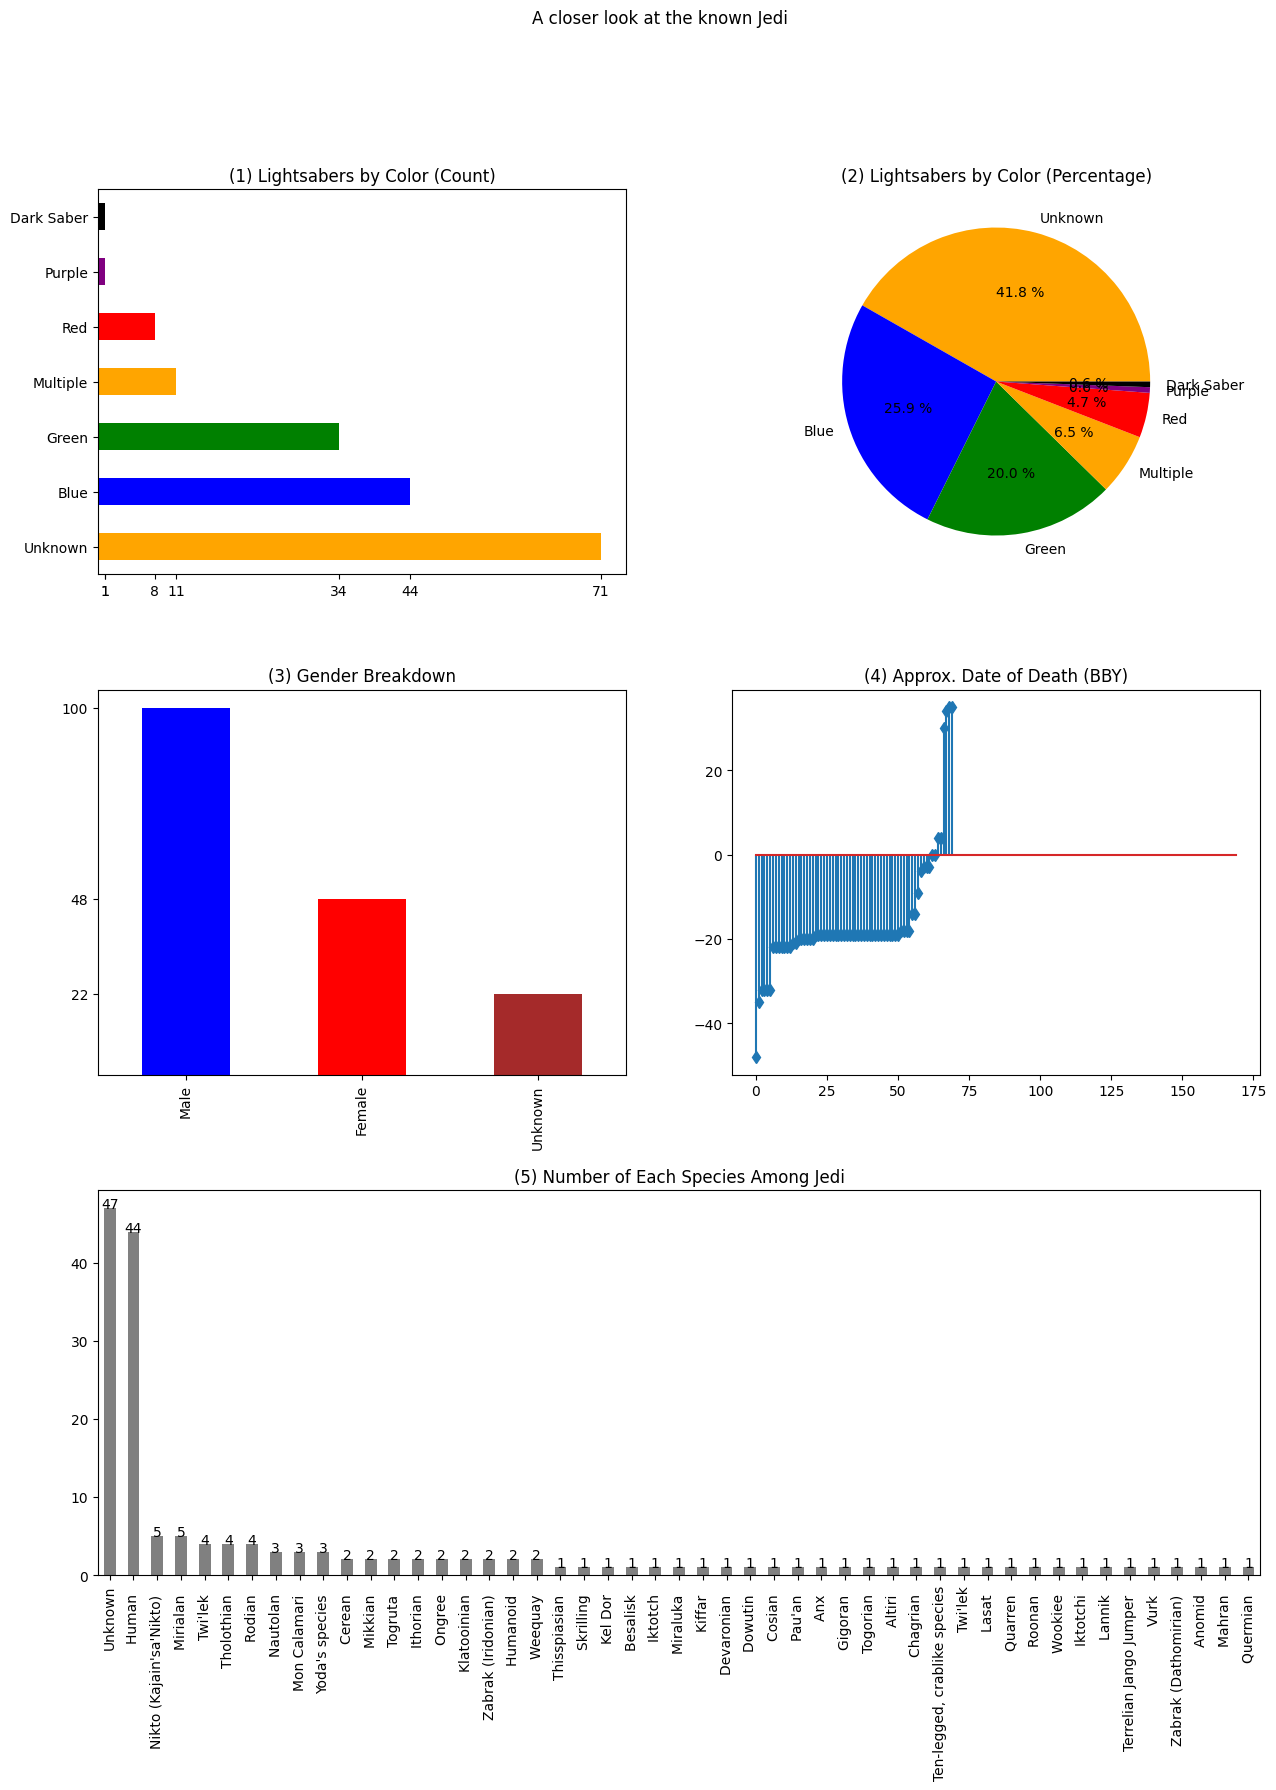

In [33]:
#Create the master figure to hold the charts
figs=plt.figure(figsize=(15,18))
figs.suptitle("A closer look at the known Jedi")

#We want to lay this out in a grid that is 2 rows wide and 3 tall
gs=figs.add_gridspec(3,2) 

#Place the lightsaber visual in the upper left location
ax1=figs.add_subplot(gs[0,0])
ax1.title.set_text('(1) Lightsabers by Color (Count)')
#First, let's look at a chart of lightsaber colors
df_sabers=pd.DataFrame(jedi_csv['Lightsaber Color'], columns=['Lightsaber Color'])
df_sabers['Lightsaber Color'].value_counts()[:20].plot(kind='barh', color=['orange','blue','green', 'orange','red','purple','black'], xticks=df_sabers['Lightsaber Color'].value_counts())

#Put the lightsaber percentage in the upper right location
ax2=figs.add_subplot(gs[0,1])
ax2.title.set_text('(2) Lightsabers by Color (Percentage)')
s=jedi_csv['Lightsaber Color'].squeeze()
s.value_counts(normalize=True).plot.pie(autopct='%.1f %%', ylabel='', legend=False, colors=['orange','blue','green','orange','red','purple','black'])

#Gender breakdown goes on left side of second row
ax3=figs.add_subplot(gs[1,0])
ax3.title.set_text('(3) Gender Breakdown')
jedi_csv['Gender'].value_counts().plot(kind='bar', color=['blue','red','brown'], yticks=jedi_csv['Gender'].value_counts())

#Date of death on right side of second row
ax4=figs.add_subplot(gs[1,1])
ax4.title.set_text('(4) Approx. Date of Death (BBY)')
jedi_csv['Date of Death Numerical']=None

#This breaks the data in that Data of Death column into a numerical column so we can plot it correctly.
for index,row in jedi_csv.iterrows():    
    if row['Date of Death'][0].isdigit():
        row['Date of Death Numerical']=re.findall(r'\d+',row['Date of Death'])
        row['Date of Death Numerical']=int(row['Date of Death Numerical'][0])
        if "BBY" in row['Date of Death']:
            row['Date of Death Numerical']=row['Date of Death Numerical']-(2*row['Date of Death Numerical'])
   
#Now I have numerical years they died, so I can plot that.

plt.stem(jedi_csv['Date of Death Numerical'].sort_values(axis=0), markerfmt='d')

#Species takes up entire third row
ax5=figs.add_subplot(gs[2,:])
ax5.title.set_text('(5) Number of Each Species Among Jedi')

jedi_csv['Species'].value_counts().plot(kind='bar', color='gray')

#Need to get these so I can add labels for values above the bars on the chart
y=jedi_csv['Species'].value_counts()
x=jedi_csv['Species'].unique()

for i in range(len(x)):
    plt.text(i,y[i], y[i],ha='center')

#Adjust the spacing above each subplot so our labels don't overlap
figs.subplots_adjust(hspace=.3) 

plt.show()

### Conclusions

**Lightsaber Color**

You can see in charts 1 & 2 that while there are a lot of Jedi whose lightsaber color is unknown, of those we do know blue is the most common, with green slightly behind it in popularity. Of the known saber colors, of the color isn't blue or green then there is a high chance the Jedi has had multiple colors of saber. These results line up perfectly with my expectations, based on the books I've read and the Jedi we see in the movies and Disney+ show.

This is hardly indicative of all Jedi to ever exist. While it is suggestive, we don't know that there weren't thousands more Jedi in the past with yellow or purple sabers. It's not conclusive data, just an indication of the breakdown in Jedi who exist during the period represented in the various media.

**Jedi Gender**

In chart 3 we can see that there are about twice as many male Jedi as female, at least of those whose gender we know. While the unknown number may continue at a similar rate, we don't know they will. This suggests more Jedi are men than are women overall, but it is only a suggestion and not proof. We don't know the total number of Jedi, which makes this hard to predict. Maybe we know of more male than female because these particular male Jedi happened to be involved in something well known, or maybe those who created the stories of the Jedi were biased toward males. The data is suggestive, not conclusive.

**Date of Death**

As you can see in chart 4, a majority of the known Jedi die around 19 BBY (Before the battle of Yavin). For those who know Star Wars history, that is when Order 66 was implemented. During Order 66 the Jedi were declared enemies of The Republic by Chancellor Palpatine and he ordered the clones to kill the Jedi. Additionally, many Jedi and their Padowans died at the hands of Darth Vader at this time. That explains this clumping of data. The data also shows that a small number of Jedi survived to live many years beyond Order 66.

There appears to be more Jedi who survived Order 66 than I would have thought. This was one outcome I didn't expect. 

**Species**

Chart 5 shows the species of known Jedi. Of all the known Jedi, an overwhelming majority of them are human, according to this data. While the total number of Twi'lek, Zabrak, Togruta, and others may add up to more than the total number of humans, the numbers are so lopsided as to show a definite trend toward human Jedi. This is a limited data set, and it may not indicate the number overall, but it is suggestive.

This lines up directly with Star Wars movies and shows. While there are a larger number of Jedi in the book who are a species other than Human, you still see slightly more humans than other species. There is no indication yet whether this has remained throughout the history of the Jedi. For all we know, 10,000 BBY there may have been thousands of Twi'lek Jedi and very few humans. Still, we can safely assume that humans make up a majority of Jedi overall.

**Additional Thoughts**

This was an incomplete view of the Jedi, based on a small sampling of data. The point of this was to explore a little about the Jedi. I didn't expect any solid conclusions,and I didn't find any.

There is more that can be done with this data, including showing the master-apprentice relationships, but I'm happy with what I've found here. 